# GMM and KDE Interpolation

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from gmm.gmm import GaussianMixture
from math import sqrt
from torchkde import KernelDensity

from torch_geometry.prob_geodesics import ProbGEORCE_Euclidean
from torch_geometry.prob_means import ProbGEORCEFM_Euclidean


## Hyper-parameters

In [2]:
max_iter = 1000
tol = 1e-4
N_grid = 100
grid_size = 100
device = "cpu"

In [3]:
plt.rcParams.update({'font.size': 25})

In [4]:
#hyper-parameters
n_data, dim = 300, 2
n_components = 2
figure_path = '../figures/gmm/'

In [5]:
torch.manual_seed(0)

In [6]:
z0 = torch.Tensor([-5.0, -4.0])
zN = torch.Tensor([17.0, 4.0])

lams = [0.0, 1.0, 10.0, 25.0, 50.0, 100.0]

## Generate Synthetic Data

In [7]:
data = torch.Tensor(n_data, dim).normal_()

data[:n_data//4] -= 2
data[:n_data//4] *= sqrt(3)
data[n_data//4:(2*n_data//4)] += 2
data[n_data//4:(2*n_data//4)] *= sqrt(2)
data[(2*n_data//4):(3*n_data//4),0] += 7
data[(2*n_data//4):(3*n_data//4),1] -= 3
data[(2*n_data//4):(3*n_data//4)] *= sqrt(2)
data[(3*n_data//4):,0] += 12
data[(3*n_data//4):,1] += 3
data[(3*n_data//4):] *= sqrt(2)

# Next, the Gaussian mixture is instantiated and ..
n_components = 2
model = GaussianMixture(n_components, dim)
model.fit(data)
# .. used to predict the data points as they where shifted
y = model.predict(data)

In [8]:
min_x1, max_x1 = torch.min(data[:,0])-2.0, torch.max(data[:,0])+2.0
min_x2, max_x2 = torch.min(data[:,1])-2.0, torch.max(data[:,1])+2.0

x1 = torch.linspace(min_x1,max_x1,100)
x2 = torch.linspace(min_x2,max_x2,100)
X1, X2 = torch.meshgrid(x1,x2)

/home/fmry/anaconda3/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Gaussian Mixture Model

In [9]:
def gmm_reg_fun(x):

    return -torch.sum(model.logp(x, as_average=False))

In [10]:
gmm_curves = {}
for lam in lams:
    print(lam)
    ProbGeodesic = ProbGEORCE_Euclidean(reg_fun=gmm_reg_fun,
                                                 init_fun=None,
                                                 lam=lam,
                                                 N=N_grid,
                                                 tol=tol,
                                                 max_iter=max_iter,
                                                 device=device,
                                                )
    curve = ProbGeodesic(z0,zN)
    logp_curve = torch.mean(model.logp(curve, as_average=False))
    gmm_curves[lam] = [curve, logp_curve.item()]

0.0
1.0
10.0
25.0
50.0
100.0


In [11]:
gmm_map = []
for u1,v1 in zip(X1,X2):
    vals = []
    for u,v in zip(u1,v1):
        vals.append(model.logp(torch.stack((u,v)), as_average=False))
    gmm_map.append(torch.stack(vals))

gmm_map = torch.stack(gmm_map)

## Kernel Density Estimation

In [12]:
data.requires_grad = True
kde = KernelDensity(bandwidth=1., kernel='gaussian') # create kde object with isotropic bandwidth matrix
_ = kde.fit(data) # fit kde to data

In [13]:
heat_kde = []
for u1,v1 in zip(X1,X2):
    vals = []
    for u,v in zip(u1,v1):
        vals.append(kde.score_samples(torch.stack((u,v)).reshape(-1,2)))
    heat_kde.append(torch.stack(vals))

heat_kde = torch.stack(heat_kde).detach().numpy()

In [14]:
def kde_reg_fun(x):

    return -torch.sum(kde.score_samples(x))

In [15]:
kde_curves = {}
for lam in lams:
    ProbGeodesic = ProbGEORCE_Euclidean(reg_fun=kde_reg_fun,
                                                 init_fun=None,
                                                 lam=lam,
                                                 N=N_grid,
                                                 tol=tol,
                                                 max_iter=max_iter,
                                                 device=device,
                                                )
    curve = ProbGeodesic(z0,zN)
    logp_curve = torch.mean(kde.score_samples(curve))
    kde_curves[lam] = [curve, logp_curve.item()]

## Plotting

/tmp/ipykernel_2409112/1162097313.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


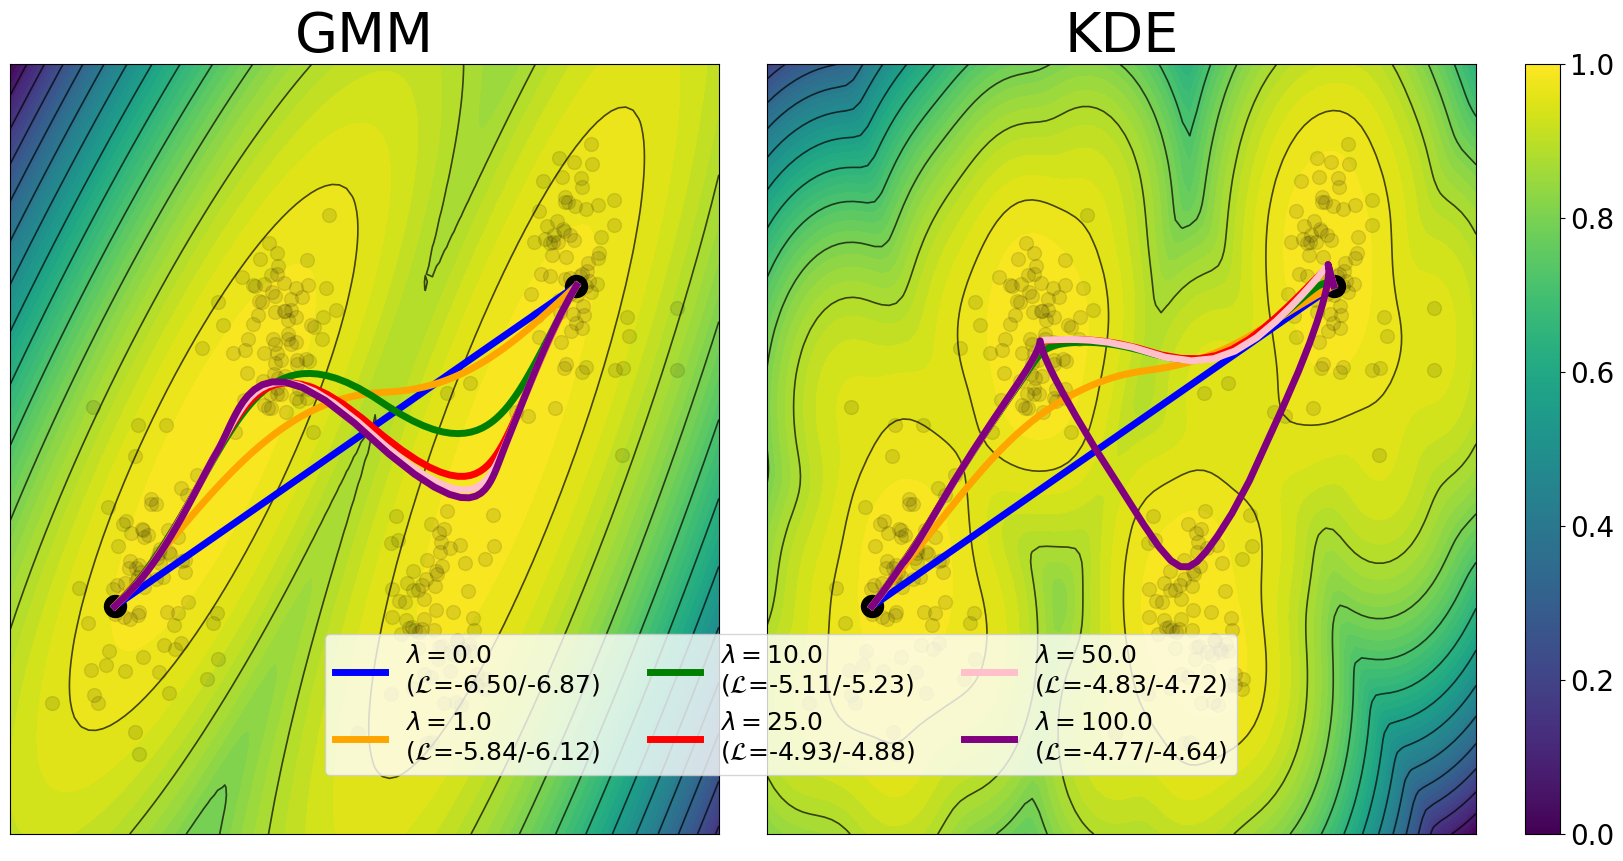

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.gridspec import GridSpec

colors = ['blue', 'orange', 'green', 'red', 'pink', 'purple']

# Normalize densities
gmm_map_norm = (gmm_map - gmm_map.min()) / (gmm_map.max() - gmm_map.min())
heat_kde_norm = (heat_kde - heat_kde.min()) / (heat_kde.max() - heat_kde.min())

# Shared axis limits
xmin, xmax = X1.min(), X1.max()
ymin, ymax = X2.min(), X2.max()

# Create figure and GridSpec
fig = plt.figure(figsize=(20,10))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)  # last column for colorbar

# -------------------------------
# LEFT PANEL — GMM
# -------------------------------
ax1 = fig.add_subplot(gs[0,0])
cf1 = ax1.contourf(X1, X2, gmm_map_norm, levels=50, cmap="viridis")
ax1.contour(X1, X2, gmm_map_norm, colors="black", linewidths=1.2, levels=15, alpha=0.7)

for (key, val), c in zip(gmm_curves.items(), colors):
    ax1.plot(val[0][:,0], val[0][:,1], color=c, linewidth=5.0)

ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
ax1.set_title("GMM", fontsize=40)
ax1.scatter(z0[0], z0[1], color='black', s=250)
ax1.scatter(zN[0], zN[1], color='black', s=250)
ax1.scatter(data.detach().numpy()[:,0], data.detach().numpy()[:,1], color='black', s=100, alpha=0.1)

# -------------------------------
# RIGHT PANEL — KDE
# -------------------------------
ax2 = fig.add_subplot(gs[0,1])
cf2 = ax2.contourf(X1, X2, heat_kde_norm.squeeze(), levels=50, cmap="viridis")
ax2.contour(X1, X2, heat_kde_norm.squeeze(), colors="black", linewidths=1.2, levels=15, alpha=0.7)

for (key, val), c in zip(kde_curves.items(), colors):
    ax2.plot(val[0][:,0], val[0][:,1], color=c, linewidth=5.0)

for (key1, val1), (key2, val2), c in zip(gmm_curves.items(), kde_curves.items(), colors):
    ax2.plot([], [], color=c,
             label=rf"$\lambda={key1}$" + "\n" + rf"($\mathcal{{L}}$={val1[1]:.2f}/{val2[1]:.2f})",
             linewidth=5.0)

ax2.set_xticks([]); ax2.set_yticks([])
ax2.set_xlim(xmin, xmax); ax2.set_ylim(ymin, ymax)
ax2.set_title("KDE", fontsize=40)
ax2.scatter(z0[0], z0[1], color='black', s=250)
ax2.scatter(zN[0], zN[1], color='black', s=250)
ax2.scatter(data.detach().numpy()[:,0], data.detach().numpy()[:,1], color='black', s=100, alpha=0.1)

# -------------------------------
# SINGLE COLORBAR OUTSIDE
# -------------------------------
cbar_ax = fig.add_subplot(gs[0,2])  # third column reserved
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

# -------------------------------
# LEGEND
# -------------------------------
lines, labels = ax2.get_legend_handles_labels()
fig.legend(lines, labels, loc=(0.20, 0.10), ncol=3, fontsize=18)

fig.tight_layout()

save_path = f'{figure_path}gmm_kde_examples.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')
plt.show()
